In [1]:
import os
import pandas as pd
from torchvision.io import read_image
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from itertools import cycle
import einops
from tqdm.notebook import tqdm
import random
from torch.distributions import Categorical


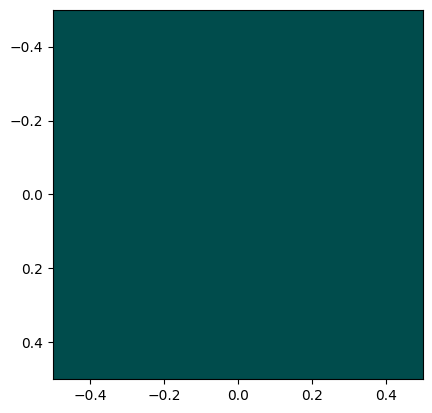

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Generate random pixel values for the image
image_data = np.random.rand(1, 1, 3)  # 100x100 image with 3 color channels (RGB)
image_data[0,0,:] = 0.3
image_data[0,0,0] = 0
# Display the image
plt.imshow(image_data)
plt.show()

In [3]:
import os
import pandas as pd
from torchvision.io import read_image
import numpy as np

class CustomImageDataset(Dataset):
    def __init__(self):
      self.num_images = 2000
      self.images = np.random.rand(self.num_images,1,1,3)

    def __len__(self):
      return len(self.images)

    def __getitem__(self, idx):
      return self.images[idx]


In [4]:
training_dataset = CustomImageDataset()

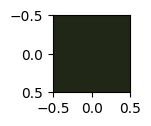

In [5]:
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure(figsize=(1, 1))
plt.imshow(training_dataset[83])
plt.show()

In [6]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_dataset, batch_size=512, shuffle=True, drop_last=True)

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomSender(nn.Module):
    def __init__(self):
        super(CustomSender, self).__init__()
        self.num_words = 10
        # Define your layers or modules here
        self.fc1 = nn.Linear(in_features=3, out_features=self.num_words)


    def forward(self, x):
        x = self.fc1(x.flatten(start_dim=1))
        return x


class CustomReceiver(nn.Module):
    def __init__(self):
        super(CustomReceiver, self).__init__()
        self.num_words = 10
        self.fc1 = nn.Linear(in_features=3, out_features=16)
        self.emb = nn.Embedding(self.num_words, 16)

    def forward_image(self, x):
        x = self.fc1(x.flatten(start_dim=1))
        return x

    def forward_text(self, x):
        x = self.emb(x)
        return x

In [18]:
m1 = CustomSender()
x = torch.randn(32,1,1,3)
alphs = m1(x).argmax(1)
m2 = CustomReceiver()
m2_img_rprs = m2.forward_image(x)
m2_text_rprs = m2.forward_text(alphs)
alphs

tensor([4, 5, 4, 4, 6, 1, 8, 5, 4, 5, 6, 6, 4, 6, 6, 8, 4, 1, 5, 4, 4, 4, 8, 4,
        4, 5, 8, 8, 6, 5, 8, 8])

In [19]:
m1_optimizer = torch.optim.Adam(m1.parameters(), lr=1e-3)
m2_optimizer = torch.optim.Adam(m2.parameters(), lr=1e-3)

In [20]:
from torch.distributions import Categorical
import copy

data_iterator = iter(train_dataloader)
acc_list = []
loss_list = []
best_acc = 0
best_model_state = None, None

for iter_num in tqdm(range(1000)):
  try:
    batch = next(data_iterator)
  except StopIteration:
    data_iterator = iter(train_dataloader)
    batch = next(data_iterator)
  m2_optimizer.zero_grad()
  m1_optimizer.zero_grad()
  #####
  message_logits = m1(batch.float())
  message = message_logits.argmax(1)
  m2_img_rprs = m2.forward_image(batch.float())
  m2_mess_rprs = m2.forward_text(message)
  rolled_m2_img_rprs = torch.roll(m2_img_rprs, shifts=1, dims=0)



  pos_similarity = F.cosine_similarity(m2_img_rprs, m2_mess_rprs).unsqueeze(1)
  neg_similarity = F.cosine_similarity(rolled_m2_img_rprs, m2_mess_rprs).unsqueeze(1)
  similarity_scores = torch.cat([pos_similarity, neg_similarity], axis=1)
  m2_loss = F.cross_entropy(similarity_scores, torch.LongTensor([0]*similarity_scores.shape[0]))
  m2_loss.backward()
  m2_optimizer.step()
  ########
  log_probs = torch.log(torch.gather(F.softmax(message_logits, dim=1), 1, message.unsqueeze(1)))
  rewards = F.cross_entropy(similarity_scores, torch.LongTensor([0]*similarity_scores.shape[0]), reduction='none').detach()
  returns = (rewards - rewards.mean()) / (rewards.std() + 1e-5)
  m1_loss = -torch.mean(returns * log_probs)
  entropy_loss = -Categorical(F.softmax(message_logits, dim=1)).entropy().sum()
  m1_loss = m1_loss + 1e-1*entropy_loss
  #####
  m1_loss.backward()
  m1_optimizer.step()
  acc = (1 - similarity_scores.argmax(1)).float().mean()
  acc_list.append(acc)
  loss_list.append(m2_loss.item())
  if acc > best_acc:
    print(acc)
    best_acc = acc
    best_model_state = copy.deepcopy(m1.state_dict()), copy.deepcopy(m2.state_dict())

  if acc.item() > 0.95:
    print(acc.item())
    break

m1.load_state_dict(best_model_state[0])
m2.load_state_dict(best_model_state[1])


  0%|          | 0/1000 [00:00<?, ?it/s]

tensor(0.4121)
tensor(0.4141)
tensor(0.4238)
tensor(0.4277)
tensor(0.4355)
tensor(0.4434)
tensor(0.4492)
tensor(0.4648)
tensor(0.4727)
tensor(0.4805)
tensor(0.5000)
tensor(0.5020)
tensor(0.5215)
tensor(0.5371)
tensor(0.5469)
tensor(0.5664)
tensor(0.5742)
tensor(0.5801)
tensor(0.5820)
tensor(0.5898)
tensor(0.5938)
tensor(0.6035)
tensor(0.6074)
tensor(0.6230)
tensor(0.6250)
tensor(0.6543)
tensor(0.6621)
tensor(0.6641)
tensor(0.6797)
tensor(0.6875)
tensor(0.6914)
tensor(0.7051)
tensor(0.7227)
tensor(0.7344)
tensor(0.7500)
tensor(0.7520)
tensor(0.7598)
tensor(0.7676)
tensor(0.7793)
tensor(0.7832)
tensor(0.7930)
tensor(0.7949)
tensor(0.8145)
tensor(0.8242)
tensor(0.8262)
tensor(0.8301)
tensor(0.8398)
tensor(0.8477)
tensor(0.8672)
tensor(0.8789)
tensor(0.8887)
tensor(0.9062)
tensor(0.9160)
tensor(0.9199)
tensor(0.9277)


<All keys matched successfully>

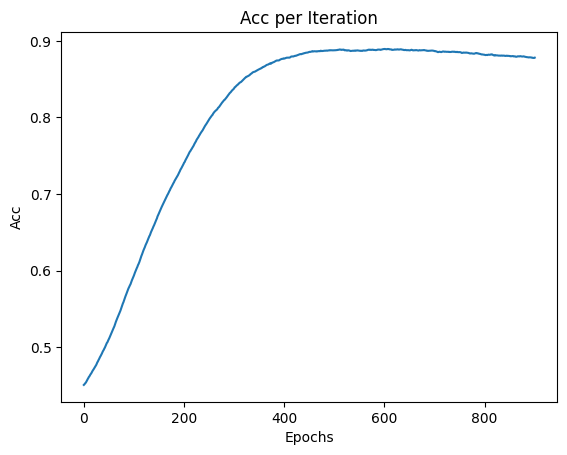

In [21]:
import numpy as np
import matplotlib.pyplot as plt
win_size = 100
smoothed_accuracy = np.convolve(acc_list, np.ones(win_size) / win_size, mode='valid')
plt.plot(smoothed_accuracy)
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.title('Acc per Iteration')
plt.show()

In [22]:
from collections import defaultdict

for batch in train_dataloader:
  message_logits = m1(batch.float())
  message = message_logits.argmax(1)

image_dictionary = defaultdict(list)
for i, m in enumerate(message):
  image_dictionary[str(m.item())].append(i)


In [23]:
image_dictionary = dict(sorted(image_dictionary.items(), key=lambda item: item[0]))

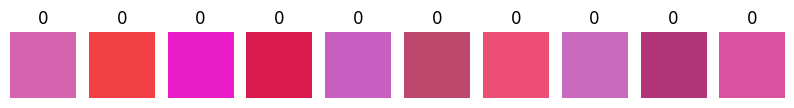

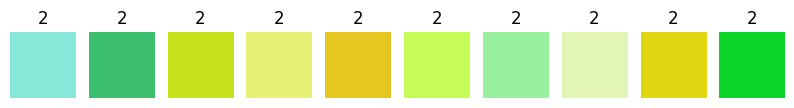

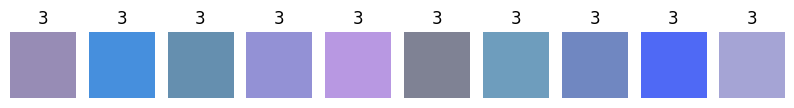

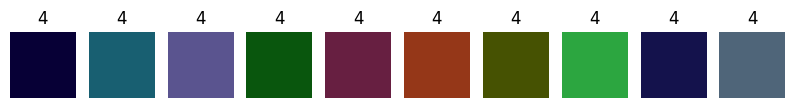

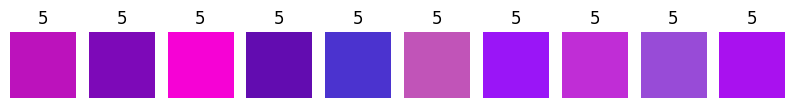

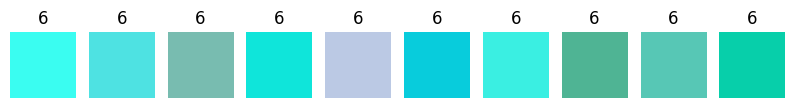

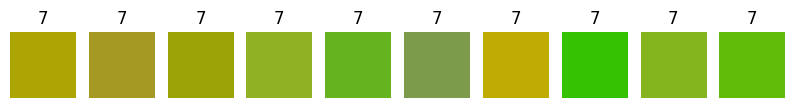

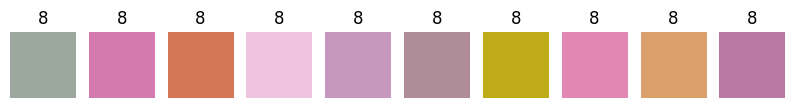

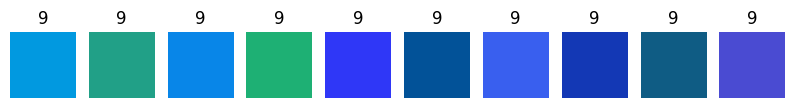

In [24]:
import matplotlib.pyplot as plt

max_image_per_token = 10
for sentence, image_indices in image_dictionary.items():
    image_indices = image_indices[:max_image_per_token]
    num_images = len(image_indices)

    if num_images == 1:
        fig = plt.figure(figsize=(1, 1))
        axs = [plt.subplot(1, 1, 1)]
    else:
        fig, axs = plt.subplots(1, num_images, figsize=(num_images, 1))
    
    for i, image_idx in enumerate(image_indices):
        axs[i].imshow(batch[image_idx])
        axs[i].set_title(f"{sentence}")
        axs[i].axis('off')

    plt.show()
